In [1]:
import time
start_time = time.time()
import progressbar
import os
import numpy as np
from keras.preprocessing import image
import cv2
import dlib
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy import stats
from sklearn import svm, datasets
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


In [3]:
import landmarks_v2 as l2

In [4]:
def get_data():
    return l2.extract_features_labels()
    
def split_data(X, Y):

    X, Y = shuffle(X,Y)
    tr_X, te_X, tr_Y, te_Y = train_test_split(X, Y, train_size=0.7)
    
    return tr_X, tr_Y, te_X, te_Y

In [5]:
X,y = get_data()

print(X.shape)
print(y.shape)

(4800, 68, 2)
(4800,)


In [7]:
Y = np.array([y, -(y - 1)]).T 

tr_X, tr_Y, te_X, te_Y = split_data(X, Y)

In [8]:
print(tr_X.shape)
print(tr_Y.shape)
print(te_X.shape)
print(te_Y.shape)

(3360, 68, 2)
(3360, 2)
(1440, 68, 2)
(1440, 2)


In [9]:
def reshapeX(X):
    return X.reshape((X.shape[0], X.shape[1] * X.shape[2]))

def reshapeY(y):
    return list(zip(*y))[0]

tr_X = reshapeX(tr_X)
te_X = reshapeX(te_X)
tr_Y = reshapeY(tr_Y)
te_Y = reshapeY(te_Y)

In [10]:
print(tr_X.shape)

(3360, 136)


In [11]:
gamma='scale'

for C in [0.1,1]:
    for degree in [1, 2, 3, 4]:
                
        lin_svc = svm.SVC(kernel='linear', C=C).fit(tr_X, tr_Y)
        print(C, "Linear:", lin_svc.score(te_X, te_Y))

        rbf_svc = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(tr_X, tr_Y)
        print( C, gamma, "Rbf:", rbf_svc.score(te_X, te_Y))

        poly_svc = svm.SVC(kernel='poly', degree=degree, C=C).fit(tr_X, tr_Y)
        print( C, degree, "Poly", poly_svc.score(te_X, te_Y))

0.1 Linear: 0.9013888888888889
0.1 scale Rbf: 0.8555555555555555
0.1 1 Poly 0.8604166666666667
0.1 Linear: 0.9013888888888889
0.1 scale Rbf: 0.8555555555555555
0.1 2 Poly 0.8763888888888889
0.1 Linear: 0.9013888888888889
0.1 scale Rbf: 0.8555555555555555
0.1 3 Poly 0.8958333333333334
0.1 Linear: 0.9013888888888889
0.1 scale Rbf: 0.8555555555555555
0.1 4 Poly 0.8951388888888889
1 Linear: 0.9027777777777778
1 scale Rbf: 0.875
1 1 Poly 0.8673611111111111
1 Linear: 0.9027777777777778
1 scale Rbf: 0.875
1 2 Poly 0.8895833333333333
1 Linear: 0.9027777777777778
1 scale Rbf: 0.875
1 3 Poly 0.8944444444444445
1 Linear: 0.9027777777777778
1 scale Rbf: 0.875
1 4 Poly 0.9027777777777778


In [12]:
from sklearn.svm import SVC as svc

In [13]:
lin = {'C': stats.uniform(1, 10), 'kernel': ['linear']}

rbf = {'C': stats.uniform(1, 10), 'gamma': stats.uniform(0.0001, 0.01), 'kernel': ['rbf']}

poly = {'C': stats.uniform(1, 10), 'degree': stats.uniform(1, 4), 'kernel': ['poly']}

def randomSearch(X, y, param_kernel):
    param_distributions = param_kernel 
    searchrand = RandomizedSearchCV(SVC(), param_distributions, n_iter=10, n_jobs=-1, refit=True, verbose=3)
    searchrand.fit(X, y)
#   printing statistical scores 
    searchrand.cv_results_
    
#    print(searchrand.cv_results_)
    return searchrand.best_params_, searchrand.best_estimator_  

# Obtaining optimum hyperparameters and classifier for different kernel
linSVC_param, lin_SVC = randomSearch(tr_X, tr_Y, lin)
rbfSVC_param, rbf_SVC = randomSearch(tr_X, tr_Y, rbf)
polySVC_param, poly_SVC = randomSearch(tr_X, tr_Y, poly)
#print(datetime.now() - start)

# Display optimum hyperparameters for SVC kernel
print('Optimum hyperparameters for linear kernel: ')
print(linSVC_param)
print('Optimum hyperparameters for rbf kernel: ')
print(rbfSVC_param)
print('Optimum hyperparameters for polynomial kernel: ')
print(polySVC_param)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 26.3min finished


{'mean_fit_time': array([ 42.86319351, 134.54837728, 234.11385045,  98.40222597,
       415.13487439,  85.59347501,  52.37077231, 439.03298478,
       402.08766651, 410.49716034]), 'std_fit_time': array([  8.71799884,  14.19251686,  43.27063944,   6.85742035,
       116.21376088,  15.90081105,   7.24157948,  92.9295045 ,
        61.37841869,  29.78693504]), 'mean_score_time': array([0.11260791, 0.10731282, 0.11289811, 0.10990577, 0.11948047,
       0.11675262, 0.12366853, 0.12110705, 0.11164503, 0.08616881]), 'std_score_time': array([0.00897267, 0.00312904, 0.00465255, 0.00317916, 0.00074606,
       0.00806031, 0.01133617, 0.00506764, 0.0232839 , 0.01638196]), 'param_C': masked_array(data=[1.251229016933845, 3.6904316102385772,
                   5.763890114534913, 2.747810778444424, 9.57287812914673,
                   2.0171501071852695, 1.3024006556404557,
                   10.48800752126697, 9.758728053614494,
                   10.839995989809484],
             mask=[False, False

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.5s finished


{'mean_fit_time': array([2.47757311, 1.46727414, 3.00875077, 1.56153088, 3.38936224,
       3.27145863, 3.20283093, 2.68343296, 3.07948828, 1.08700142]), 'std_fit_time': array([0.0644307 , 0.01821018, 0.05338659, 0.04568227, 0.08029478,
       0.07065161, 0.04802832, 0.20827623, 0.32589268, 0.1739924 ]), 'mean_score_time': array([0.28802872, 0.18031864, 0.54924426, 0.2233058 , 0.50076294,
       0.57187014, 0.54753551, 0.29481249, 0.47713289, 0.15379496]), 'std_score_time': array([0.0222432 , 0.0090401 , 0.01890543, 0.03528421, 0.02528669,
       0.02416321, 0.02749514, 0.02499024, 0.09296489, 0.0279862 ]), 'param_C': masked_array(data=[3.210775005312925, 10.186203809374742,
                   8.029937216685447, 3.002185814141008,
                   9.758123901586497, 8.424677569295659,
                   3.096245900909357, 7.474366347208107,
                   9.143364980836731, 6.032974563111113],
             mask=[False, False, False, False, False, False, False, False,
            

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.1s finished


{'mean_fit_time': array([0.81721425, 1.46052704, 1.47876759, 1.45815568, 1.08589764,
       1.57661033, 0.89062819, 0.98098707, 1.00940814, 0.86430364]), 'std_fit_time': array([0.09046234, 0.10942306, 0.06010334, 0.05098638, 0.02979232,
       0.03327095, 0.06855781, 0.07664366, 0.02717374, 0.07676315]), 'mean_score_time': array([0.12207408, 0.11967969, 0.12906775, 0.2277905 , 0.12147822,
       0.12366872, 0.12999544, 0.12716303, 0.14341683, 0.0935606 ]), 'std_score_time': array([0.02282628, 0.01259958, 0.01296756, 0.01965157, 0.0077054 ,
       0.01414488, 0.00704894, 0.00713357, 0.01238311, 0.00862368]), 'param_C': masked_array(data=[4.385023066183646, 8.697770499061054,
                   6.9624105619906445, 3.942389544865043,
                   9.673848787494284, 8.458458576970397,
                   5.131725800641961, 3.560314375842936, 2.74720688528629,
                   7.185559640131561],
             mask=[False, False, False, False, False, False, False, False,
             

In [14]:
# printing validation accuracy scores for each kernel
print(lin_SVC.score(te_X, te_Y))
print(rbf_SVC.score(te_X, te_Y))
print(poly_SVC.score(te_X, te_Y))

0.9034722222222222
0.8930555555555556
0.9034722222222222


Automatically created module for IPython interactive environment


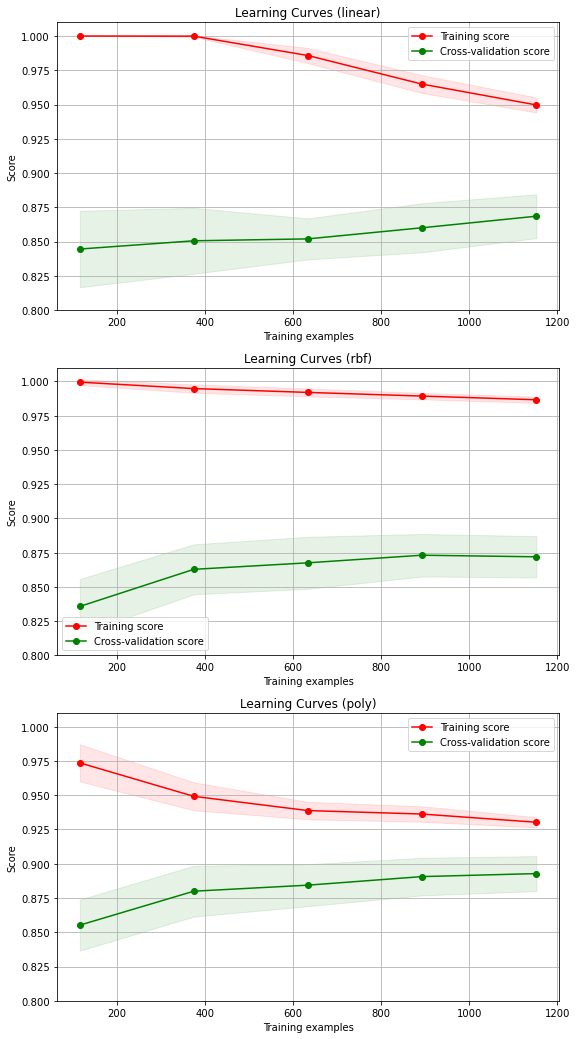

In [15]:
print(__doc__)


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
        axes.set_xlabel("Training examples")
        axes.set_ylabel("Score")

        train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                           train_sizes=train_sizes,
                           return_times=True)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        fit_times_mean = np.mean(fit_times, axis=1)
        fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
        axes.grid()
        axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color="r")
        axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1,
                             color="g")
        axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
        axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
        axes.legend(loc="best")

    return plt

plt.figure(figsize=(9,18))

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)


# estimator = poly_SVC 
# plot_learning_curve(estimator, title, te_X, te_Y, axes=axes, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)
axes = plt.subplot(311)
title = r"Learning Curves (linear)"
plot_learning_curve(lin_SVC, title, te_X, te_Y, axes=axes, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)

axes = plt.subplot(312)
title = r"Learning Curves (rbf)"
plot_learning_curve(rbf_SVC, title, te_X, te_Y, axes=axes, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)

axes = plt.subplot(313)
title = r"Learning Curves (poly)"
plot_learning_curve(poly_SVC, title, te_X, te_Y, axes=axes, ylim=(0.8, 1.01), cv=cv, n_jobs=-1)


plt.show()